### import packages

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

### Load data with pandas

In [10]:
train_df = pd.read_csv('../input/train.csv', index_col='Id')
test_df = pd.read_csv('../input/test.csv', index_col='Id')

In [11]:
train_df.info()
print('------------------------------')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

In [12]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [13]:
test_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


### explore data

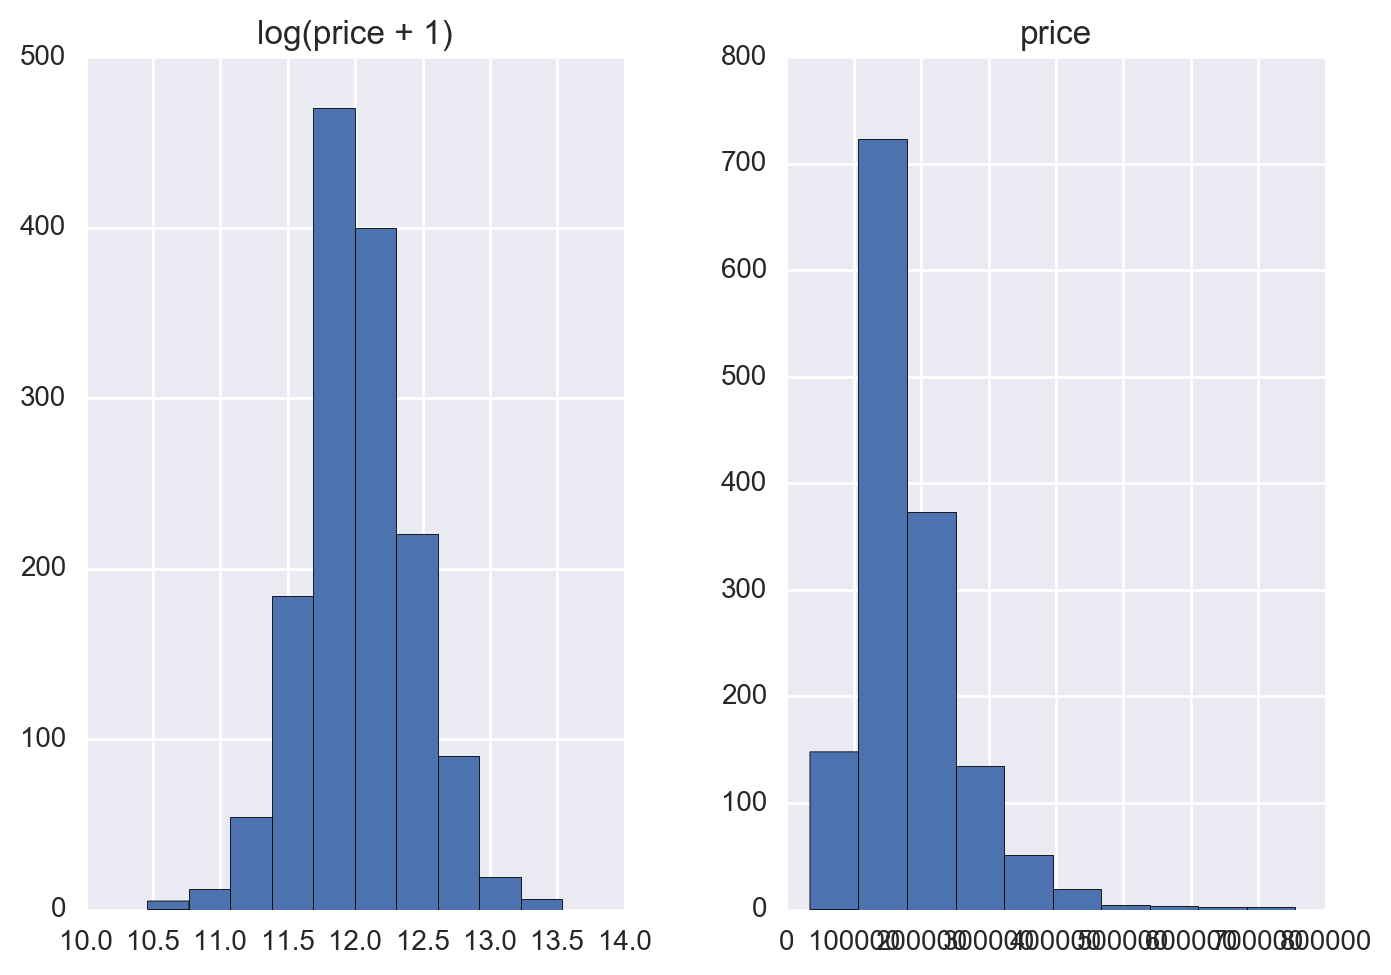

In [14]:
import matplotlib
plt.figure(figsize=(3, 18))
prices = pd.DataFrame({"price":train_df["SalePrice"], "log(price + 1)":np.log1p(train_df["SalePrice"])})
prices.hist()
target = np.log1p(prices.price)

In [15]:
concat = pd.concat([train_df.drop(['SalePrice'], axis=1), test_df])

numFeat = concat.dtypes[concat.dtypes != object].index
strFeat = concat.dtypes[concat.dtypes == object].index
floatFeat = concat.dtypes[concat.dtypes == float].index
concat[strFeat] = concat[strFeat].fillna('NA')

In [16]:
from scipy.stats import skew
concat_skew = concat[numFeat].apply(lambda x : skew(x.dropna()))
train_skew = train_df[numFeat].apply(lambda x : skew(x.dropna()))
#pd.DataFrame([concat_skew, train_skew], index=['concat', 'train']).T.sort_values(by='concat', ascending=False)
skew_feat = concat_skew[concat_skew > 0.75].index
concat[skew_feat] = np.log1p(concat[skew_feat])

In [30]:
flrArea = concat['1stFlrSF'] + concat['2ndFlrSF']
validArea = np.log1p(flrArea + 0.7 * concat.TotalBsmtSF + concat.GarageArea)
concat['ValidArea'] = validArea

### Murge training data and test data
For more reliable data distribution to analyse we combine train data and test data

### Numerical Features
Fill nan numerical features with mean of column lucky that NAN are much fewer than valid integers
### Non-numerical Features(string features) 
As the 'NA' value has special meaning in the object type variables, replace them with "NA" instead of guessing their value

In [31]:
concat[floatFeat].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 11 columns):
LotFrontage     2919 non-null float64
MasVnrArea      2919 non-null float64
BsmtFinSF1      2919 non-null float64
BsmtFinSF2      2919 non-null float64
BsmtUnfSF       2919 non-null float64
TotalBsmtSF     2919 non-null float64
BsmtFullBath    2919 non-null float64
BsmtHalfBath    2919 non-null float64
GarageYrBlt     2919 non-null float64
GarageCars      2919 non-null float64
GarageArea      2919 non-null float64
dtypes: float64(11)
memory usage: 273.7 KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11efb8050>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12921e090>]], dtype=object)

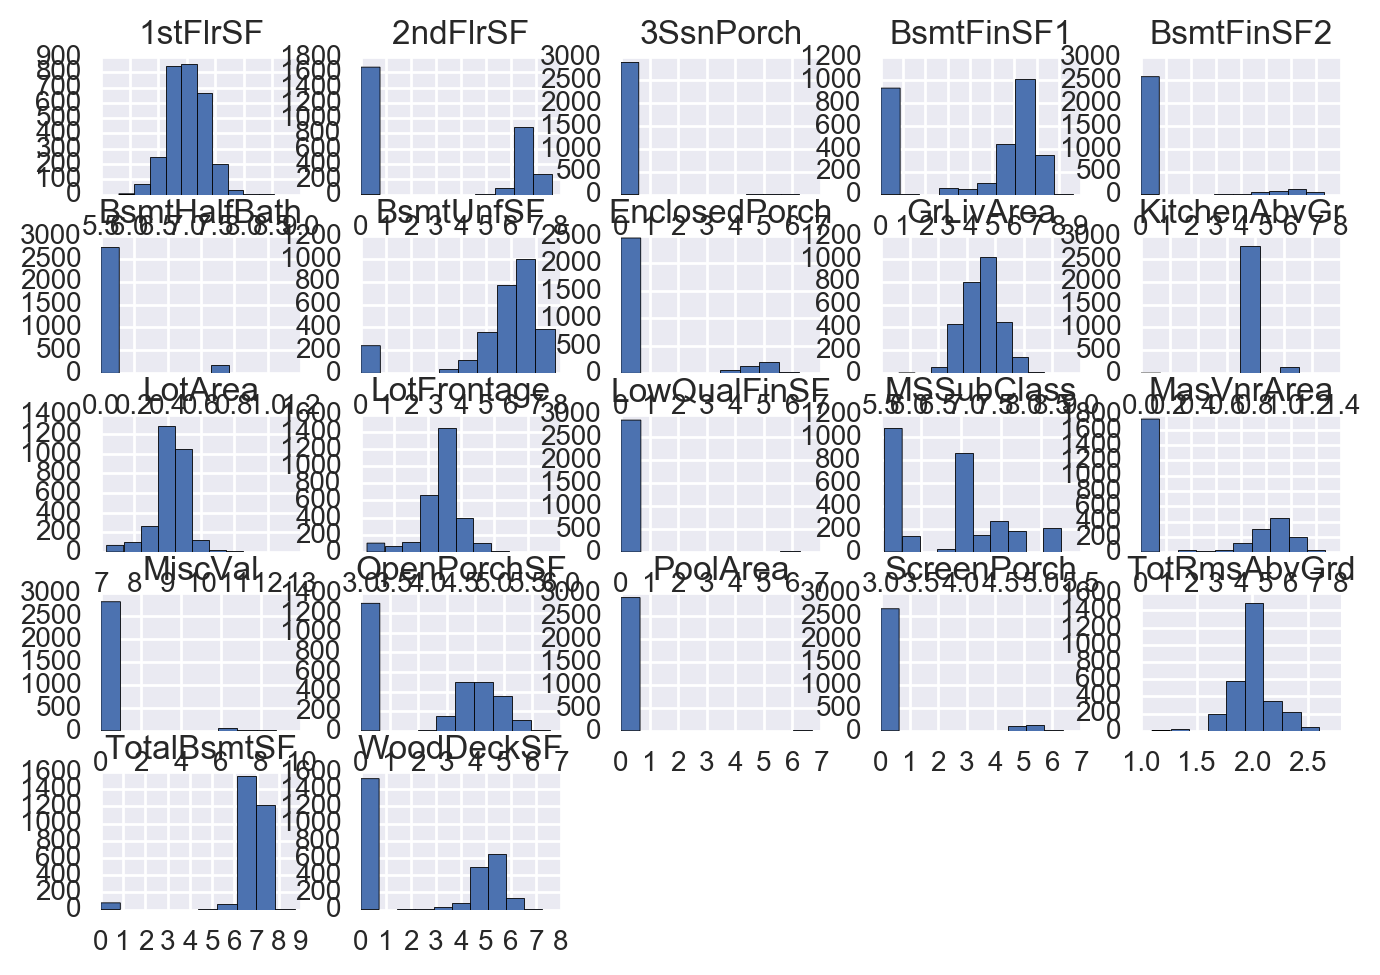

In [32]:
concat[skew_feat].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1293c3150>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12a3f5150>]], dtype=object)

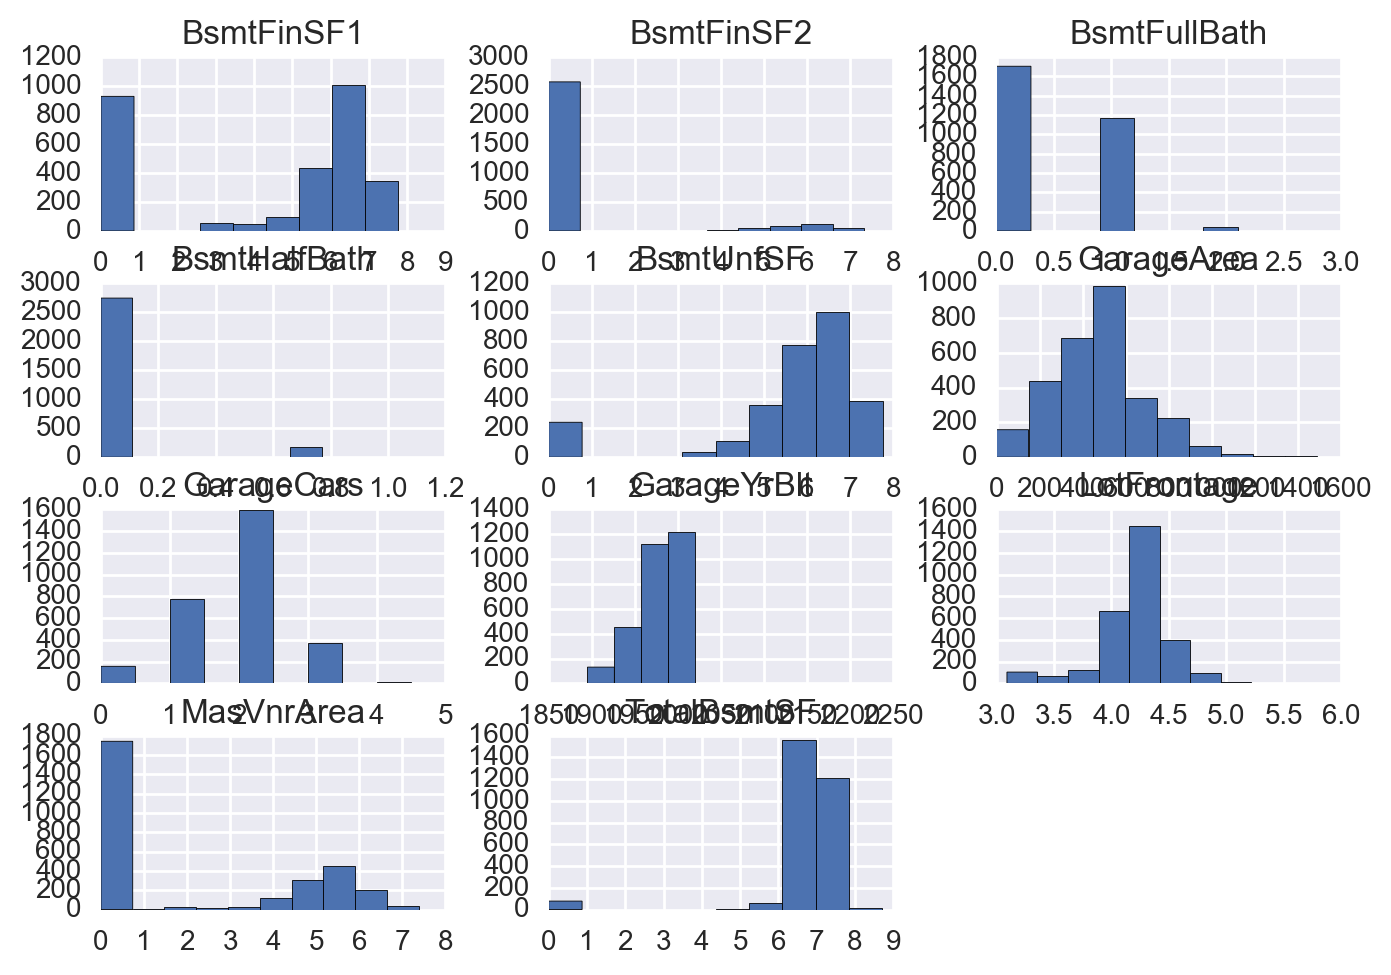

In [33]:
concat[floatFeat].fillna(concat[floatFeat].mean()).hist()

In [34]:
concat[floatFeat] = concat[floatFeat].fillna(concat[floatFeat].mean())

concat[numFeat] = concat[numFeat].astype(float)
concat = concat.join(pd.get_dummies(concat[strFeat]))
concat.drop(strFeat, inplace=True, axis=1)

KeyError: "Index([u'MSZoning', u'Street', u'Alley', u'LotShape', u'LandContour',\n       u'Utilities', u'LotConfig', u'LandSlope', u'Neighborhood',\n       u'Condition1', u'Condition2', u'BldgType', u'HouseStyle', u'RoofStyle',\n       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',\n       u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual', u'BsmtCond',\n       u'BsmtExposure', u'BsmtFinType1', u'BsmtFinType2', u'Heating',\n       u'HeatingQC', u'CentralAir', u'Electrical', u'KitchenQual',\n       u'Functional', u'FireplaceQu', u'GarageType', u'GarageFinish',\n       u'GarageQual', u'GarageCond', u'PavedDrive', u'PoolQC', u'Fence',\n       u'MiscFeature', u'SaleType', u'SaleCondition'],\n      dtype='object') not in index"

In [52]:
# return to train_df and test_df
train_df = concat[:train_df.shape[0]]
test_df = concat[train_df.shape[0]:]

### Models
With package __scikit learn__.
Preprocessing Steps:
> 1. User Stander scale with matrix
> 2. Try classic tree-like model to calculate feature importance
> 3. 

In [36]:
from sklearn.cross_validation import cross_val_score

def rmse(model):
    rmse = np.sqrt(-cross_val_score(model, train_df.values, y=target, scoring='mean_squared_error'))
    return rmse.mean()

def get_result(model, desc):
    y_pred = np.expm1(model.predict(test_df.values))
    output_name = '../output/' + desc + '.csv'
    output(output_name, y_pred)

def output(path, y_pred):
    out_df = pd.DataFrame(y_pred, index=test_df.index, columns=['SalePrice'])
    out_df.to_csv(path)

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

scaler = StandardScaler().fit(train_df)
train = scaler.transform(train_df)
test = scaler.transform(test_df)

X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.33, random_state=42)

In [53]:
train_df.ValidArea

Id
1       6.340768
2       6.159392
3       6.441534
4       6.493964
5       6.752195
6       6.212000
7       6.476414
8       6.222198
9       6.188995
10      5.383635
11      5.983461
12      6.628129
13      5.898769
14      6.749260
15      5.900248
16      6.377507
17      6.200005
18      6.261812
19      6.378304
20      5.727032
21      6.772050
22      5.678574
23      6.305785
24      6.371322
25      5.644895
26      6.806307
27      6.377689
28      6.666512
29      5.806612
30      5.527979
          ...   
1431    5.969284
1432    6.115168
1433    5.431176
1434    6.153546
1435    6.208482
1436    6.164089
1437    6.292488
1438    6.669325
1439    6.841500
1440    6.343675
1441    6.538639
1442    6.069501
1443    6.723438
1444    5.321357
1445    6.460441
1446    5.531451
1447    5.783940
1448    6.355851
1449    5.997505
1450    2.481603
1451    2.963077
1452    6.749366
1453    6.286729
1454    2.562440
1455    6.023651
1456    6.172133
1457    6.241788
1458    5.6

### Random Forest

In [54]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=500, n_jobs=7)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=7, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [65]:
rmse(rf_model)

0.14581993323637374

In [55]:
importance = pd.Series(rf_model.feature_importances_, index=train_df.columns).sort_values(ascending=False)

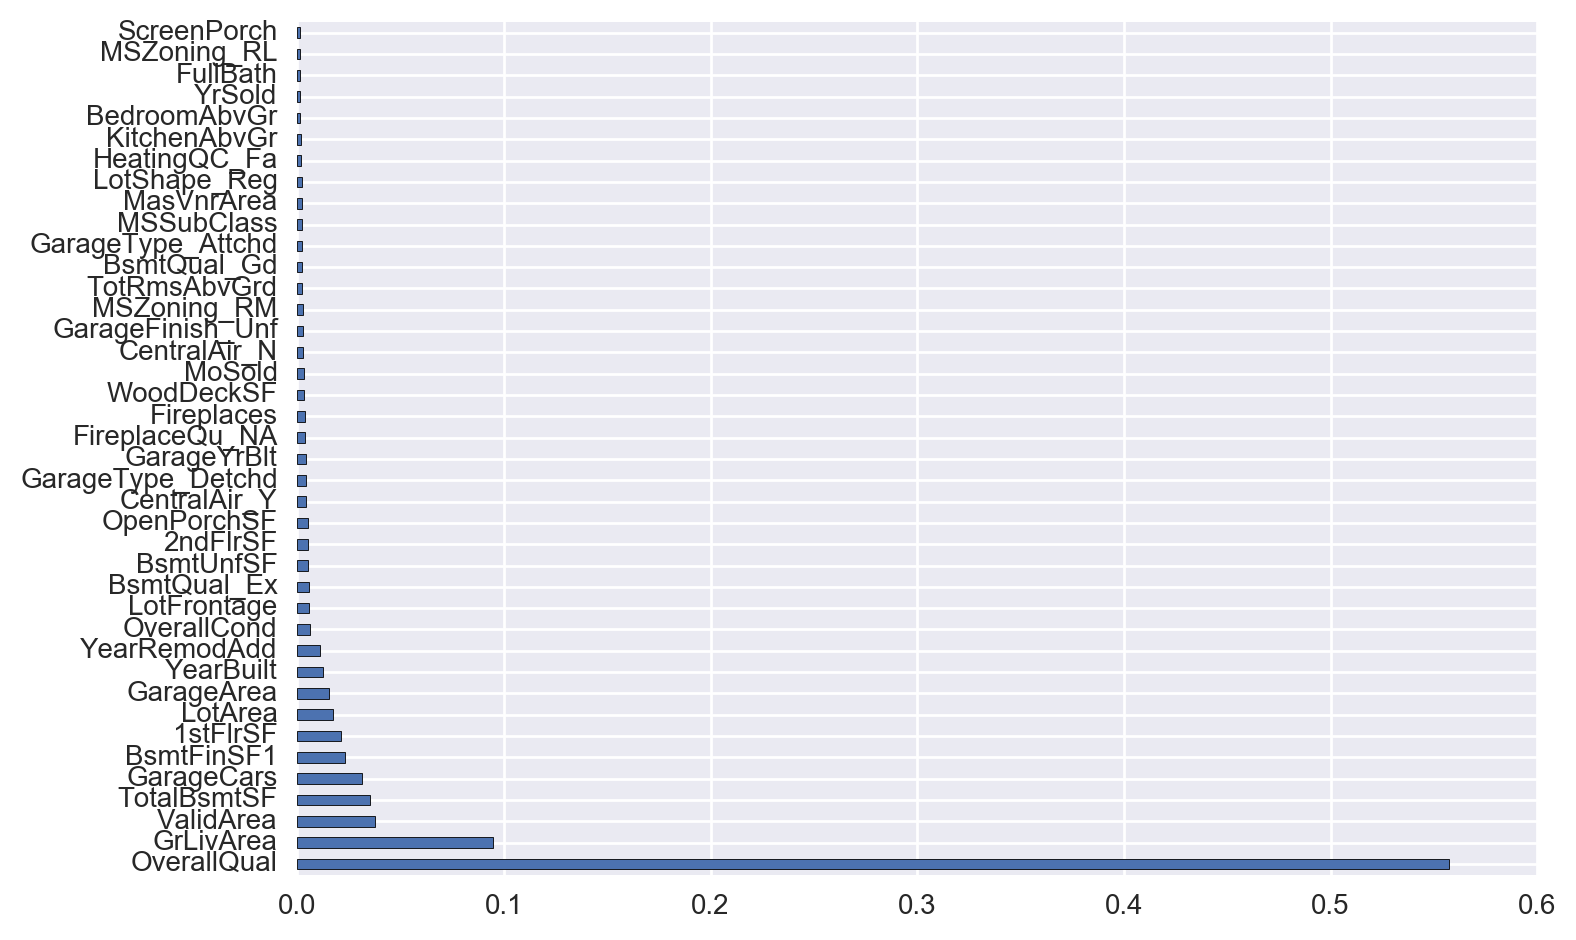

In [57]:
importance[importance > 1e-3].plot(kind='barh')

### Lasso

In [61]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(alpha=4e-4)
lasso_model.fit(X_train, y_train)

Lasso(alpha=0.0004, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [62]:
pd.Series(lasso_model.coef_, index=train_df.columns).sort_values()

RoofMatl_ClyTile        -0.048459
Condition2_PosN         -0.026127
MSZoning_C (all)        -0.025151
Heating_Grav            -0.019709
Neighborhood_Edwards    -0.016031
SaleCondition_Abnorml   -0.015603
Exterior1st_Wd Sdng     -0.014628
GarageQual_Po           -0.014450
Functional_Maj2         -0.012779
Condition1_Artery       -0.012169
CentralAir_N            -0.011166
SaleType_WD             -0.011086
Neighborhood_NAmes      -0.010921
HouseStyle_2Story       -0.010678
BsmtQual_TA             -0.010519
Foundation_BrkTil       -0.010088
MiscFeature_Othr        -0.009711
GarageCond_Ex           -0.009670
Neighborhood_MeadowV    -0.009562
BsmtCond_Fa             -0.009129
BldgType_Duplex         -0.008515
Neighborhood_NWAmes     -0.008332
Condition1_RRAe         -0.008049
BsmtExposure_No         -0.007998
KitchenAbvGr            -0.007813
BsmtUnfSF               -0.007810
LandContour_Bnk         -0.007694
ExterCond_Gd            -0.007613
Functional_Sev          -0.007254
GarageCond_Fa 

In [63]:
rmse(lasso_model)

0.12406520087375024

In [64]:
alpha = np.arange(1e-5, 1e-3, 1e-5)
[rmse(Lasso(alpha=a)) for a in alpha]

/Users/prince/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


[0.13526505862980376,
 0.13378783845720188,
 0.13255064295363836,
 0.13151914140548451,
 0.13059676546445195,
 0.12979141625094529,
 0.12907841582316951,
 0.12840252482031345,
 0.12773690229358056,
 0.12726948783859868,
 0.1269499413200578,
 0.12667524019015505,
 0.12641981437468922,
 0.12618818011979718,
 0.12597797984941886,
 0.12578772520453516,
 0.12561519349988234,
 0.12544063815171067,
 0.12528184622322339,
 0.12513404954739957,
 0.12501369373709478,
 0.12493158989242252,
 0.1248376021335716,
 0.12475157646086399,
 0.12466864592793654,
 0.12459210400051475,
 0.12452018233218458,
 0.12446290509875955,
 0.12440724219780767,
 0.12435233951324549,
 0.12430431568401168,
 0.12426269330752564,
 0.12421629538903071,
 0.1241751417145021,
 0.12414129452332112,
 0.1241082918940848,
 0.12408664429149963,
 0.12407053790250462,
 0.12406456280686645,
 0.12406520087375024,
 0.1240622543432478,
 0.12405957935688339,
 0.12406002712607563,
 0.12406459071609739,
 0.12407408671102105,
 0.124092552091

### GBDT && XGBOOST

In [149]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=400)
rmse(xgb)
xgb.fit(train_df.values, target)
get_result(xgb, desc='xgb') # A bit lower in scoring than gbdt

In [122]:
gbdt = GradientBoostingRegressor(n_estimators=500)
print model
rmse(model)
gbdt.fit(train_df.values, target)
get_result(gbdt, 'gbdt') # Kaggle scoring 0.13194 

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)


### Grid Parameter CV Search 

In [152]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV
gbdt = GradientBoostingRegressor(learning_rate=0.1)
grid = { 
    'learning_rate' : [0.1, 0.05, 0.2, 0.01],
    'n_estimators' : [100, 200, 500],
    'max_depth' : [3, 4, 5]
}
search = GridSearchCV(gbdt, grid, scoring='mean_squared_error')
print GridSearchCV
search.fit(X_train, y_train)

<class 'sklearn.grid_search.GridSearchCV'>


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200, 500], 'learning_rate': [0.1, 0.05, 0.2, 0.01], 'max_depth': [3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

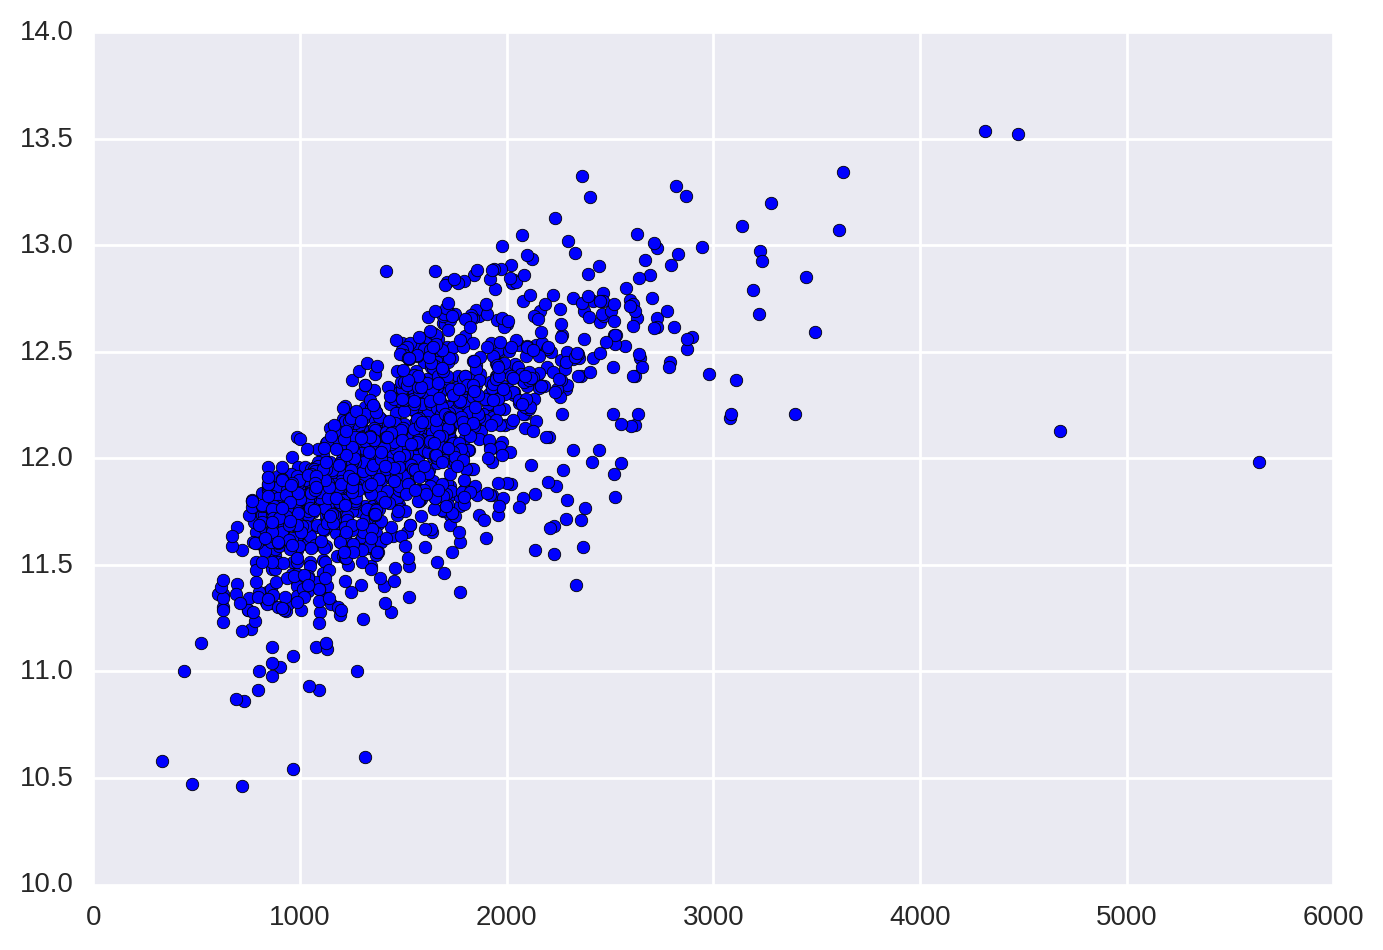

In [154]:
plt.scatter(train_df.GrLivArea, target)

In [88]:
print search.best_params_
print search.best_estimator_
print np.sqrt(-search.best_score_)

{'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 3}
GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)
0.138886784411


In [229]:
from sklearn.cross_validation import cross_val_score
rf = RandomForestRegressor(n_estimators=1000)
#rf.fit(train_df[bestFeat].values, target)

In [191]:
rmse(rf)

array([ 0.14168532,  0.1558891 ,  0.14050501])

In [196]:
from scipy.stats import pearsonr
pearson = train_df[numFeat].apply(lambda x : pearsonr(x.dropna(), target.ix[x.notnull()])[0])
pearson.sort_values(ascending=False)

OverallQual      0.817185
GrLivArea        0.700927
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
TotRmsAbvGrd     0.534422
GarageYrBlt      0.501656
Fireplaces       0.489450
MasVnrArea       0.429498
BsmtFinSF1       0.372023
LotFrontage      0.335555
WoodDeckSF       0.334135
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
LotArea          0.257320
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209043
ScreenPorch      0.121208
PoolArea         0.069798
MoSold           0.057330
3SsnPorch        0.054900
BsmtFinSF2       0.004832
BsmtHalfBath    -0.005149
MiscVal         -0.020021
OverallCond     -0.036868
YrSold          -0.037263
LowQualFinSF    -0.037963
MSSubClass      -0.073959
KitchenAbvGr    -0.147548
EnclosedPorch   -0.149050
dtype: float64

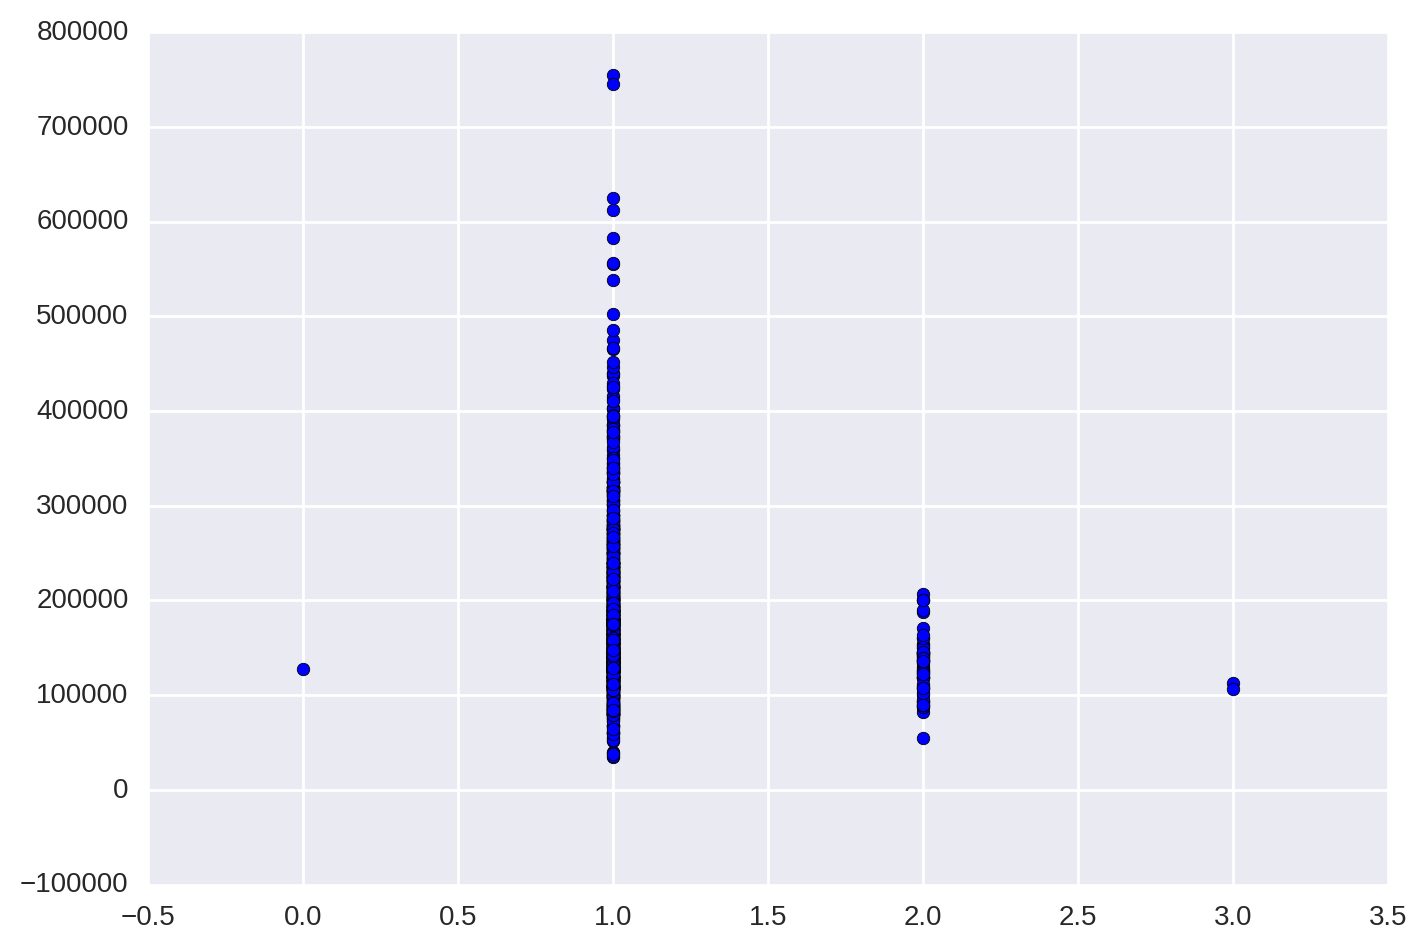

In [85]:
plt.scatter(train_df.KitchenAbvGr, train_df.SalePrice)

In [64]:
train_df[floatFeat].apply(lambda x : pearsonr(x.dropna(), train_df.SalePrice.ix[x.notnull()]))

LotFrontage      (0.351799096571, 2.60244181239e-36)
MasVnrArea       (0.477493047096, 1.45850864259e-83)
BsmtFinSF1       (0.386419806242, 3.39410982929e-53)
BsmtFinSF2        (-0.0113781214502, 0.663998650834)
BsmtUnfSF        (0.214479105547, 1.18297579636e-16)
TotalBsmtSF      (0.613580551559, 9.4842293915e-152)
BsmtFullBath     (0.227122233131, 1.55034413721e-18)
BsmtHalfBath      (-0.0168441542974, 0.520153635728)
GarageYrBlt      (0.486361677488, 8.70512794214e-83)
GarageCars      (0.640409197258, 2.49864416718e-169)
GarageArea      (0.623431438918, 5.26503816798e-158)
dtype: object

In [105]:
train_df.dtypes[train_df.dtypes == float]

LotFrontage    float64
MasVnrArea     float64
GarageYrBlt    float64
dtype: object

In [106]:
concat.dtypes[concat.dtypes == float]

LotFrontage     float64
MasVnrArea      float64
BsmtFinSF1      float64
BsmtFinSF2      float64
BsmtUnfSF       float64
TotalBsmtSF     float64
BsmtFullBath    float64
BsmtHalfBath    float64
GarageYrBlt     float64
GarageCars      float64
GarageArea      float64
dtype: object

In [118]:
type(train_df.LotFrontage[8])

numpy.float64

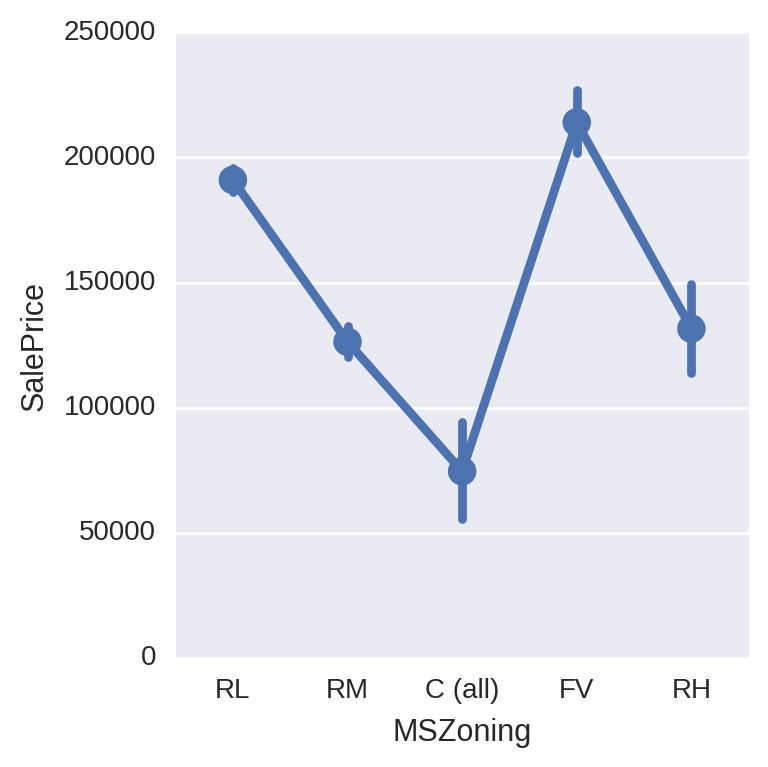

In [121]:
sns.factorplot(x='MSZoning', y='SalePrice', data=train_df)

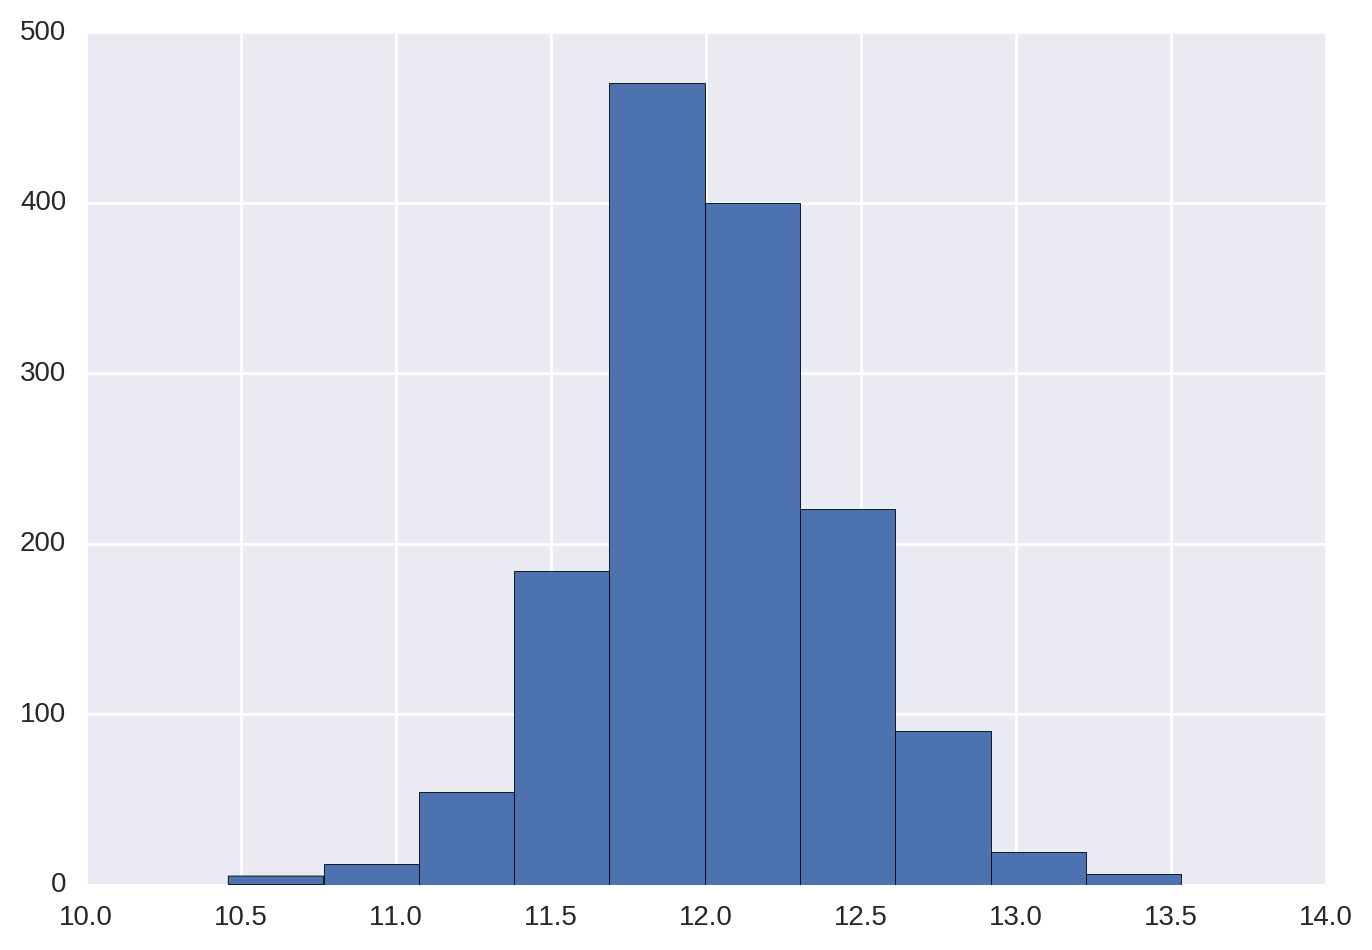

In [11]:
np.log1p(train_df.SalePrice).hist()